In [ ]:
# set the matplotlib backend so figures can be saved in the background
import matplotlib
matplotlib.use("Agg")
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dropout ,Flatten,Dense,Input,AveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50V2
from keras.applications.resnet_v2 import preprocess_input
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import itertools 

In [ ]:
 baseModel = ResNet50V2(weights="imagenet", include_top=False,input_tensor=Input(shape=(224, 224, 3)))

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
train_path='/content/drive/MyDrive/senario1_224/train'
valid_path='/content/drive/MyDrive/senario1_224/valid'
test_path='/content/drive/MyDrive/senario1_224/test'
testC_path='/content/drive/MyDrive/senario1_224/testC'
testC2_path='/content/drive/MyDrive/senario2_224/testC'
IMAGE_SIZE = [224, 224]

In [ ]:
'''
imname='/content/drive/MyDrive/s1_suez_jpg2/20141109.jpg'
Image(filename=imname)
preprocessed_image = prepare_image(imname)
predictions = mobile.predict(preprocessed_image)
results = imagenet_utils.decode_predictions(predictions)
results
'''

"\nimname='/content/drive/MyDrive/s1_suez_jpg2/20141109.jpg'\nImage(filename=imname)\npreprocessed_image = prepare_image(imname)\npredictions = mobile.predict(preprocessed_image)\nresults = imagenet_utils.decode_predictions(predictions)\nresults\n"

In [ ]:
baseModel = ResNet50V2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
#headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
#headModel = Dense(16, activation="relu")(headModel)
headModel = Dense(2, activation="sigmoid")(headModel)
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the training process
for layer in baseModel.layers:
	layer.trainable = False

In [ ]:
model.summary()    

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
______________________________________________________________________________________________

In [ ]:
train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input,
                                   #rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   vertical_flip= True,
                                   rotation_range=30,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   fill_mode="nearest"
                                   ) #included in our dependencies

trainGen=train_datagen.flow_from_directory(train_path,
                                                 target_size=IMAGE_SIZE,
                                                 color_mode='rgb',
                                                class_mode='categorical',
                                                 batch_size=8,
                                                 shuffle=True)

valid_datagen=ImageDataGenerator(preprocessing_function=preprocess_input,
                                  #rescale = 1./255
                                 )
valGen=valid_datagen.flow_from_directory(valid_path,
                                                 target_size=IMAGE_SIZE,
                                                 color_mode='rgb',
                                                  class_mode='categorical',
                                                 batch_size=8,
                                                 shuffle=True)

validC_generator=valid_datagen.flow_from_directory(valid_path,
                                                 target_size=IMAGE_SIZE,
                                                 color_mode='rgb',
                                                  class_mode='categorical',
                                                 batch_size=8,
                                                 shuffle= False)

test_datagen=ImageDataGenerator(preprocessing_function=preprocess_input,
                                #rescale = 1./255
                                )

test_generator=test_datagen.flow_from_directory(test_path,
                                                 target_size=IMAGE_SIZE,
                                                 color_mode='rgb',
                                                 batch_size=8,
                                                 shuffle=True)

testC_generator=test_datagen.flow_from_directory(testC_path,
                                                 target_size=IMAGE_SIZE,
                                                 color_mode='rgb',
                                         
                                                 batch_size=8,
                                                 shuffle= False
                                                 )
testC2_generator=test_datagen.flow_from_directory(testC2_path,
                                                 target_size=IMAGE_SIZE,
                                                 color_mode='rgb',
                                         
                                                 batch_size=8,
                                                 shuffle= False
                                                 )


Found 113 images belonging to 2 classes.
Found 26 images belonging to 2 classes.
Found 26 images belonging to 2 classes.
Found 13 images belonging to 1 classes.
Found 13 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [ ]:
def show_grid(image_list,nrows,ncols,label_list=None,show_labels=False,savename=None,figsize=(10,10),showaxis='off'):
    if type(image_list) is not list:
        if(image_list.shape[-1]==1):
            image_list = [image_list[i,:,:,0] for i in range(image_list.shape[0])]
        elif(image_list.shape[-1]==3):
            image_list = [image_list[i,:,:,:] for i in range(image_list.shape[0])]
    fig = plt.figure(None, figsize,frameon=False)
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(nrows, ncols),  # creates 2x2 grid of axes
                     axes_pad=0.3,  # pad between axes in inch.
                     share_all=True,
                     )
    for i in range(nrows*ncols):
        ax = grid[i]
        ax.imshow(image_list[i],cmap='Greys_r')  # The AxesGrid object work as a list of axes.
        ax.axis('off')
        if show_labels:
            ax.set_title(class_mapping[y_int[i]])
    if savename != None:
        plt.savefig(savename,bbox_inches='tight')

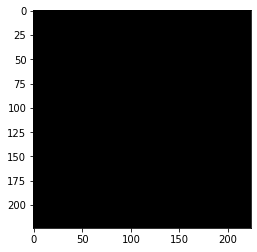

In [ ]:
#print(testC_generator[0][0][0])
import matplotlib.pyplot as plt
imgplot = plt.imshow((testC_generator[0][0][7]).astype('uint8'))

In [ ]:
# compile the model
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)
# train the model

r = model.fit(
	trainGen,
	steps_per_epoch=8,
	validation_data=valGen,
	validation_steps=4,
	epochs=50)

Epoch 1/50
8/8 [==============================] - 7s 291ms/step - loss: 1.2285 - accuracy: 0.8434 - val_loss: 1.1058 - val_accuracy: 0.9231
Epoch 2/50
8/8 [==============================] - 1s 143ms/step - loss: 0.3203 - accuracy: 0.9427 - val_loss: 2.5847 - val_accuracy: 0.9231
Epoch 3/50
8/8 [==============================] - 1s 123ms/step - loss: 1.3604 - accuracy: 0.8834 - val_loss: 1.8034 - val_accuracy: 0.8846
Epoch 4/50
8/8 [==============================] - 1s 135ms/step - loss: 0.0449 - accuracy: 0.9938 - val_loss: 1.4776 - val_accuracy: 0.9231
Epoch 5/50
8/8 [==============================] - 1s 123ms/step - loss: 0.0936 - accuracy: 0.9559 - val_loss: 1.8844 - val_accuracy: 0.9231
Epoch 6/50
8/8 [==============================] - 1s 139ms/step - loss: 1.1370e-05 - accuracy: 1.0000 - val_loss: 2.4280 - val_accuracy: 0.8846
Epoch 7/50
8/8 [==============================] - 1s 125ms/step - loss: 1.1492 - accuracy: 0.9049 - val_loss: 1.0519 - val_accuracy: 0.9231
Epoch 8/50
8/8 [

In [ ]:
model.evaluate(trainGen)
model.evaluate(valGen)
model.evaluate(testC_generator)

2/2 [==============================] - 0s 309ms/step - loss: 7.1478 - accuracy: 0.8462


[7.14777135848999, 0.8461538553237915]

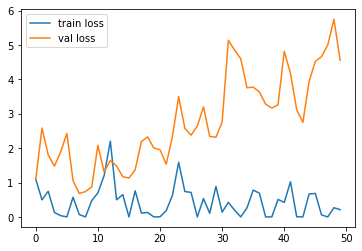

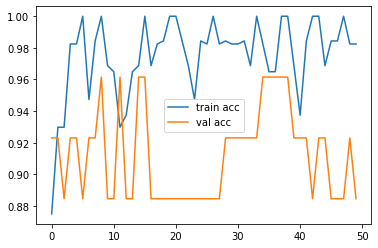

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
# loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')


In [ ]:
from keras.models import load_model
modelsavedir='/content/drive/MyDrive/senario1_model/'
modelname='spill_new_Resnetv2_model.h5'
model.save(modelsavedir+modelname)
#np.save(modelsavedir+'Resnetgood1.npy',r.history)

from tensorflow.keras.models import load_model
new_model = load_model(modelsavedir+modelname)

predited
 [1 0 0 0 0 0 0 0 0 1 0 1 1 1 1 1]
True
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
[[9 3]
 [0 4]]
              precision    recall  f1-score   support

    notspill       1.00      0.75      0.86        12
       spill       0.57      1.00      0.73         4

    accuracy                           0.81        16
   macro avg       0.79      0.88      0.79        16
weighted avg       0.89      0.81      0.82        16

Confusion matrix, without normalization
[[9 3]
 [0 4]]


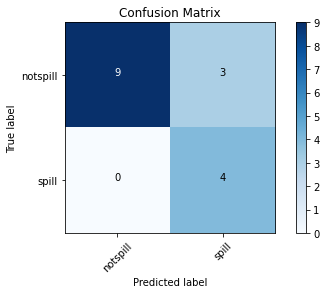

In [ ]:
import sklearn.metrics as metrics
probabilities = new_model.predict(testC2_generator)
probabilities
predicted_classes=np.argmax(probabilities, axis=1)
print('predited\n',predicted_classes)
true_classes = testC2_generator.classes
print('True\n',true_classes)
confusion_matrix = metrics.confusion_matrix(y_true=true_classes, y_pred=predicted_classes)  # shape=(12, 12)
print(confusion_matrix)
class_labels = list(testC2_generator.class_indices.keys()) 
report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)    
cm_plot_labels = ['notspill','spill']
plot_confusion_matrix(cm=confusion_matrix, classes=cm_plot_labels, title='Confusion Matrix')

predited
 [0 0 0 0 0 0 0 1 0 1 1 1 1]
True
 [0 0 0 0 0 0 0 0 0 0 1 1 1]
[[8 2]
 [0 3]]
              precision    recall  f1-score   support

    notspill       1.00      0.80      0.89        10
       spill       0.60      1.00      0.75         3

    accuracy                           0.85        13
   macro avg       0.80      0.90      0.82        13
weighted avg       0.91      0.85      0.86        13

Confusion matrix, without normalization
[[8 2]
 [0 3]]


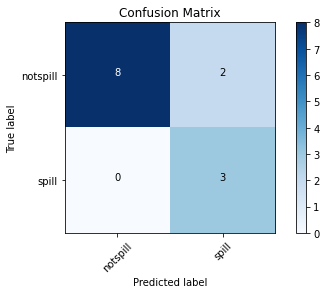

In [ ]:
import sklearn.metrics as metrics
probabilities = new_model.predict(testC_generator)
probabilities
predicted_classes=np.argmax(probabilities, axis=1)
print('predited\n',predicted_classes)
true_classes = testC_generator.classes
print('True\n',true_classes)
confusion_matrix = metrics.confusion_matrix(y_true=true_classes, y_pred=predicted_classes)  # shape=(12, 12)
print(confusion_matrix)
class_labels = list(testC_generator.class_indices.keys()) 
report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)    
cm_plot_labels = ['notspill','spill']
plot_confusion_matrix(cm=confusion_matrix, classes=cm_plot_labels, title='Confusion Matrix')

predited
 [0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
True
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
[[18  2]
 [ 1  5]]
              precision    recall  f1-score   support

    notspill       0.95      0.90      0.92        20
       spill       0.71      0.83      0.77         6

    accuracy                           0.88        26
   macro avg       0.83      0.87      0.85        26
weighted avg       0.89      0.88      0.89        26

Confusion matrix, without normalization
[[18  2]
 [ 1  5]]


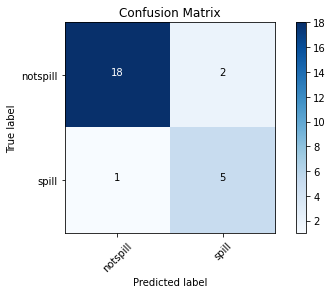

In [ ]:
probabilities = new_model.predict(validC_generator)
probabilities
predicted_classes=np.argmax(probabilities, axis=1)
print('predited\n',predicted_classes)
true_classes = validC_generator.classes
print('True\n',true_classes)
confusion_matrix = metrics.confusion_matrix(y_true=true_classes, y_pred=predicted_classes)  # shape=(12, 12)
print(confusion_matrix)
class_labels = list(validC_generator.class_indices.keys()) 
report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)    
plot_confusion_matrix(cm=confusion_matrix, classes=cm_plot_labels, title='Confusion Matrix')

In [ ]:
def load_image(img_path, show=False):

    img = image.load_img(img_path, target_size=(224,224))
    img_tensor = image.img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor /= 255.                                      # imshow expects values in the range [0, 1]

    if show:
        plt.imshow(img_tensor[0])                           
        plt.axis('off')
        plt.show()

    return img_tensor

In [ ]:

#img_path = 'C:/Users/Ferhat/Python Code/Workshop/Tensoorflow transfer learning/blue_tit.jpg'
img_path = '/content/drive/MyDrive/s1_suez_jpg2/20180715.jpg'
new_image = load_image(img_path)
pred = model.predict(new_image)
pred

NameError: ignored